# ASSIGNMENT 3

#### CITS5508 Machine Learning, Callum Brown (22985036)

# Section 1 - A Model for Diagnosing Cancer

Identifying the nature of a tumour is one of the most important medical aspects of treating cancer. Using machine learning strategies, we can accurately predict whether a tumour is harmless (benign) or cancerous (malignant) by analysing the data taken from previously diagnosed tumour tissue. By building a dataset of features from diagnosed cell nuclei, we can construct a model that can detect potentially malignant (or benign) features within the cell nuclei of undiagnosed tumours, aiding doctors in their process of diagnosis.

Throughout the project we will use a random_state value of 5508. 

## Task 1

## 1.0 Loading and Prepping the Data

We will start by re-examining data from assignment two, within the breast cancer wisconsin dataset. We first load the data, then clean, scale and perform feature selection on it before using it in our machine learning algorithms to improve the performance of the models in the long run. After a quick scan of the data, it is obvious the column 'id' is simply a unique identifier for each datapoint, and so we remove it as it will have no positive impact on the machine learning algorithms except to slow the model down as it would have more data to sift through.

Our target vector will be the 'diagnosis' column is it what we aim to predict with our models. Our feature matrix will contain the remaining columns in the dataset. We then construct a correlation matrix with our feature matrix in order to compare the linearity of features of the tumours, allowing us to remove data that wouldn't further optimise our models. With the help of a function, we remove the three highly correlating features: 'perimeter_mean', 'area_mean' and 'concave points_mean'.

We then split our data into training and testing feature matrices, 80/20 as the dataset is small, scaling the feature data using standard scaling, after fitting it to the training set so as to avoid data leakage into the 'unseen' testing data.  

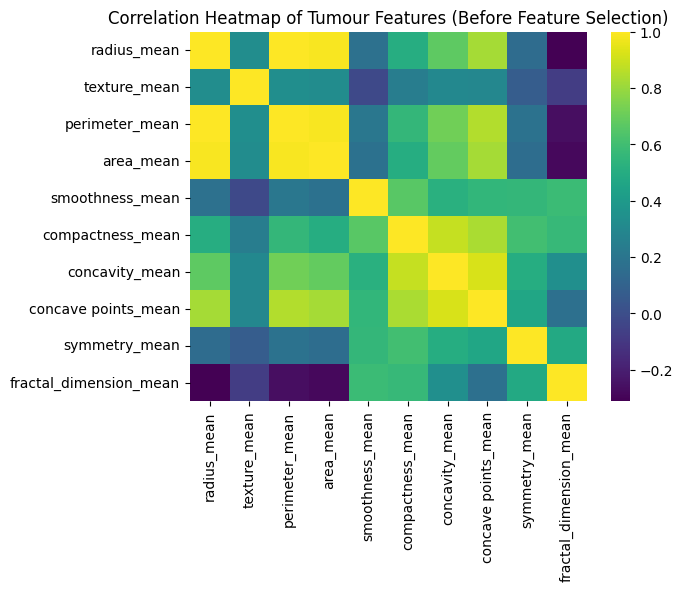

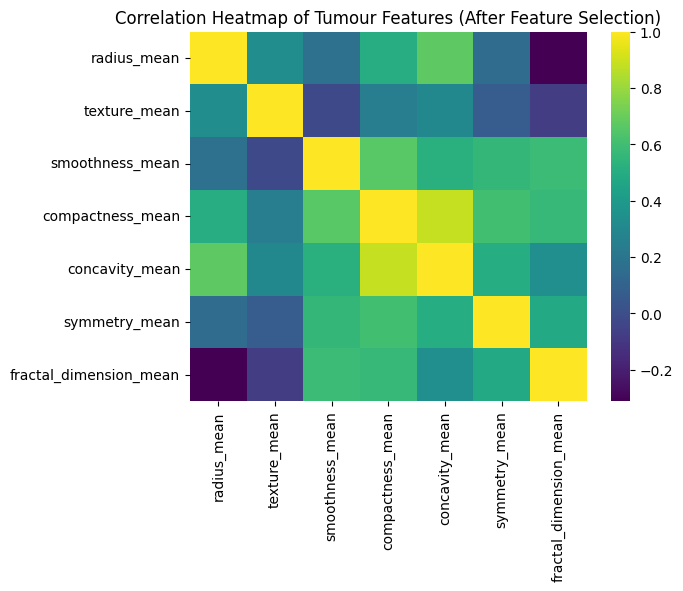

RESULTS OF DATA PREPARATION

Original dataset dimensions:  (569, 12)

Dropped 'id' feature, new dataset dimensions:  (569, 11)
Dropped 0 null rows.
Dropped 3 highly correlated features: ['perimeter_mean', 'area_mean', 'concave points_mean']

Split the data into target vector, size: 569, and feature matrix, dimension: (569, 7)
There are 7 remaining features.

Split the data 80/20 into training, size: (455, 7) and testing, size: (114, 7)


In [1]:
# 1.1.0
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# define our random state value for consistency across the project
random_state = 5508

# a function for obtaining the features of a correlation matrix with a threshold value above a specified value.
def get_linear_features(data, threshold):
    linear_features = []
    # for each row in the correlation matrix
    for row in data:
        # skip the feature if it is already identified to be above the threshold
        if row in linear_features:
            continue
        # otherwise look at each column for the row
        for column in data:
            # skip the column that matches the row as they are the same feature
            if row == column: 
               continue
            # if the entry at [row, column] is above the threshold, the feature is added to the list to be dropped
            if data.at[row, column] > threshold or data.at[row, column] < -threshold:
                linear_features.append(column)
    return linear_features

# loading the breast cancer wisconsin data into a dataframe
breast_cancer1 = pd.read_csv("breast-cancer.csv")

# dropping the id column
breast_cancer2 = breast_cancer1.drop("id", axis=1)

# dropping any rows containing null values
breast_cancer3 = breast_cancer2.dropna()

# define the targets (y) and features (x)
y = breast_cancer3["diagnosis"]
x = breast_cancer3.drop("diagnosis", axis=1)

# construct correlation matrix and plot a heatmap
x_corr = x.corr()
# using seaborn's heatmap
sns.heatmap(x_corr, cmap='viridis')
plt.title("Correlation Heatmap of Tumour Features (Before Feature Selection)")
plt.show()

# call the 'get_linear_features' function to obtain a list of linearly correlated features, defining our threshold at 0,9
linear_features = get_linear_features(x_corr, 0.9)

# drop these features from our feature matrix as they will contribute minimally/negatively to the improvement of the model
x = x.drop(linear_features, axis=1)

# construct another correlation matrix and plot our heatmap again, after feature selection
x_corr_afs = x.corr()
sns.heatmap(x_corr_afs, cmap='viridis')
plt.title("Correlation Heatmap of Tumour Features (After Feature Selection)")
plt.show()

# splitting the data into 80% training and 20% testing
x_tr, x_te, y_tr, y_te = train_test_split(x, y, test_size=0.2, random_state=random_state)

# initialise and fit a standard scaler to transform training and testing feature data
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr)
x_te = scaler.transform(x_te)

# printing some useful information for analysis of the dataset
print("RESULTS OF DATA PREPARATION\n")
print("Original dataset dimensions: ", breast_cancer1.shape)
print("\nDropped 'id' feature, new dataset dimensions: ", breast_cancer2.shape)
print("Dropped {} null rows.".format(breast_cancer3.size-breast_cancer2.size))
print("Dropped {} highly correlated features: {}".format(len(linear_features), linear_features))
print("\nSplit the data into target vector, size: {}, and feature matrix, dimension: {}".format(y.size, x.shape))
print("There are {} remaining features.".format(len(x.columns)))
print("\nSplit the data 80/20 into training, size: {} and testing, size: {}".format(x_tr.shape, x_te.shape))

## 1.1 Building a Logistic Regression Model

After first constructing and predicting our testing values using a default logistic regressor, we find the accuracy scores to be suitable, and probably usable, however we will perform fine tuning to see if we can further improve the performance of our logistic regressor.

Here we employ the use of a parameter grid to define some common selections of hyperparameters (fine tuning) for use in the training of a logistic regression model. By using this parameter grid, we can perform a grid search using three-fold cross-validation to determine the combination of these hyperparameters that constructs the model with the highest performance (best accuracy when predicting unseen data). The 'C' value denotes 'regularisation strength' or how close the model should fit to the training data, while the 'penalty' value controls the technique used for regularisation. There are more hyperparameters, however the ones used below have the greatest impact on model performance. The fine tuning here has little impact on the performance of the model, only improving the training accuracy slightly, still at a value not indicative of overfitting, so we will use this model.

In [2]:
# 1.1.1
# importing packages
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression

# define the parameter grid for some common hyperparameters for use in grid search.
parameter_grid = {
    # regularisation strength (how close the model fits the training data)
    'C': [0.01, 0.1, 1, 10],
    # the regularisation algorithm
    'penalty': ['l1', 'l2']
}

# construct a logistic regression object
lr = LogisticRegression(random_state=random_state)

# use the default model to make predictions to measure accuracy
lr.fit(x_tr, y_tr)
ylr_te = lr.predict(x_te)
ylr_tr = lr.predict(x_tr)

# perform three fold cross validation using grid search to optimise the model
lrn = LogisticRegression(random_state=random_state, solver='liblinear')
grid_search = GridSearchCV(lrn, parameter_grid, cv=3)
grid_search.fit(x_tr, y_tr)

# A list of the best parameters
best_params = grid_search.best_params_

# re-train the model with the best parameters from the grid search
lr_f = LogisticRegression(random_state=random_state, **best_params)

# fit the model to the training data and predict the target values of the testing data
lr_f.fit(x_tr, y_tr)
lr_yp = lr_f.predict(x_te)
lr_yptr = lr_f.predict(x_tr)

# print the results of the fine tuning 
print("Logistic Regression Model:\n")
print("Performance without Fine Tuning:")
print("\tTraining Accuracy: {:.2f}%".format(100*accuracy_score(y_tr, ylr_tr)))
print("\tTesting Accuracy: {:.2f}%".format(100*accuracy_score(y_te, ylr_te)))
print("\nPerformance after Fine Tuning:")
print("Best hyperparameters:", best_params)
print("\tTraining Accuracy: {:.2f}%".format(100*accuracy_score(y_tr, lr_yptr)))
print("\tTesting Accuracy: {:.2f}%".format(100*accuracy_score(y_te, lr_yp)))

Logistic Regression Model:

Performance without Fine Tuning:
	Training Accuracy: 93.63%
	Testing Accuracy: 96.49%

Performance after Fine Tuning:
Best hyperparameters: {'C': 0.1, 'penalty': 'l2'}
	Training Accuracy: 93.85%
	Testing Accuracy: 96.49%


## 1.2 Building a Decision Tree Model

Similar to 1.1.1 we again define a parameter grid to fine tune hyperparameters using grid search, this time focusing on optimising a decision tree model. Constructing a model without fine tuning, we see the accuracy scores on the training and testing set are good values, but the training accuracy score is 100%, indicative of the model overfitting the training data. The accuracy score on the testing data is decent, however we will need to fine tune the decision tree to prevent the model overfitting the training data if we want a clinically viable model.

The hyperparameters in this case are all concerned with limiting the complexity of the decision tree in different ways. 'max_depth' limits the maximum number of levels or generations a tree can have, not allowing the tree to continue splitting once it reaches a certain height. 'min_samples_leaf' limits the minimum number of datapoints a 'leaf' or child node can contain. If a parent were to split and form a child node with less than this number, it would be prevented from doing so. Finally, 'min_samples_split' prevents nodes splitting if they contain less datapoints than the specified value. 

After fine tuning, our training accuracy score is reduced to an acceptable value, and our testing accuracy score is increased, and so fine tuning has improved the viability of our model at accurately classifying breast cancer data.

Decision Tree Model:

Performance without Fine Tuning:
	Training Accuracy: 100.00%
	Testing Accuracy: 92.11%

Performance after Fine Tuning:
Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
	Training Accuracy: 95.16%
	Testing Accuracy: 93.86%

Visualisation:


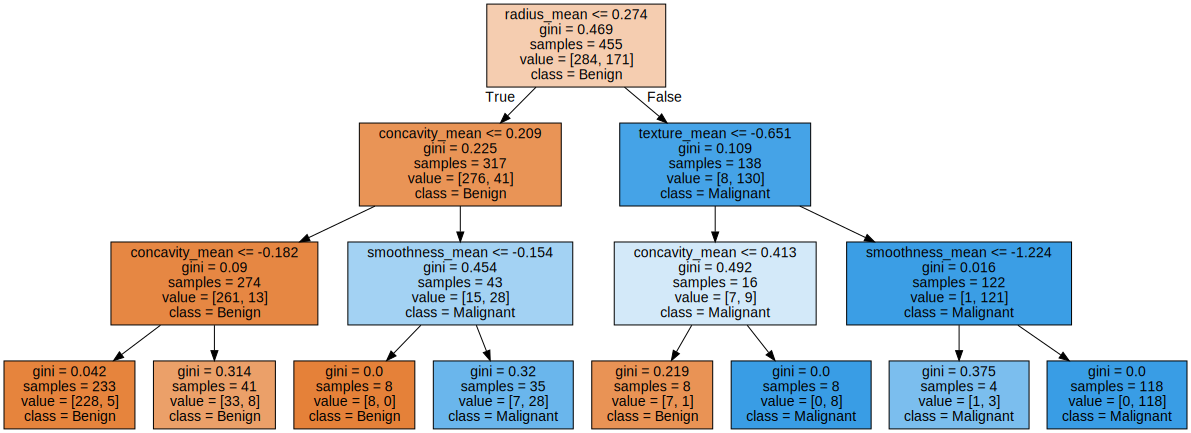

In [3]:
# 1.1.2
# importing packages
from sklearn.tree import export_graphviz
from graphviz import Source

# define the parameter grid for some common hyperparameters for use in grid search.
parameter_grid = {
    'max_depth': [None, 2, 3, 4, 5, 7],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8]
}

# construct a decision tree classifier object
dt = DecisionTreeClassifier(random_state=random_state)

# run a default test of the model
dt.fit(x_tr, y_tr)
yte_dt = dt.predict(x_te)
ytr_dt = dt.predict(x_tr)

# three fold cross validation using grid search to optimise the model
dtn = DecisionTreeClassifier(random_state=random_state)
grid_search = GridSearchCV(dtn, parameter_grid, cv=3)
grid_search.fit(x_tr, y_tr)

# A list of the best parameters
best_params = grid_search.best_params_

# retrain the classifier with the best parameters found by the grid search
dt_f = DecisionTreeClassifier(random_state=69, **best_params)

# fit the model to the training data and predict the target values of the testing data
dt_f.fit(x_tr, y_tr)
dt_yp = dt_f.predict(x_te)
dt_ytrp = dt_f.predict(x_tr)

# Print the results of the cross-validation grid search
print("Decision Tree Model:\n")
print("Performance without Fine Tuning:")
print("\tTraining Accuracy: {:.2f}%".format(100*accuracy_score(y_tr, ytr_dt)))
print("\tTesting Accuracy: {:.2f}%".format(100*accuracy_score(y_te, yte_dt)))
print("\nPerformance after Fine Tuning:")
print("Best hyperparameters:", best_params)
print("\tTraining Accuracy: {:.2f}%".format(100*accuracy_score(y_tr, dt_ytrp)))
print("\tTesting Accuracy: {:.2f}%".format(100*accuracy_score(y_te, dt_yp)))

# Plot decision tree diagram
print("\nVisualisation:")
export_graphviz(dt_f,
                out_file="dt_f.dot", 
                feature_names=x.columns, 
                class_names=["Benign", "Malignant"], 
                max_depth=3, 
                filled=True)
Source.from_file("dt_f.dot")

## 1.3 Comparing the Performance of the two Models

From accuracy score alone, we can see the logistic regression model is performing better than the decision tree classifier at classifying new data, with four incorrect classifications to seven out of a total 114 rows in the testing data. The logistic regressor also wins with precision and f1-scores beating out the decision tree's scores, however, they share an approximately equal recall score.  

In the context of tumour diagnosis, the most important factor for a machine learning model would be the accuracy at classifying new tumour data (or performance on the testing data), and so we will select the model with the best accuracy for use in a clinical setting; the Decision Tree Classifier.

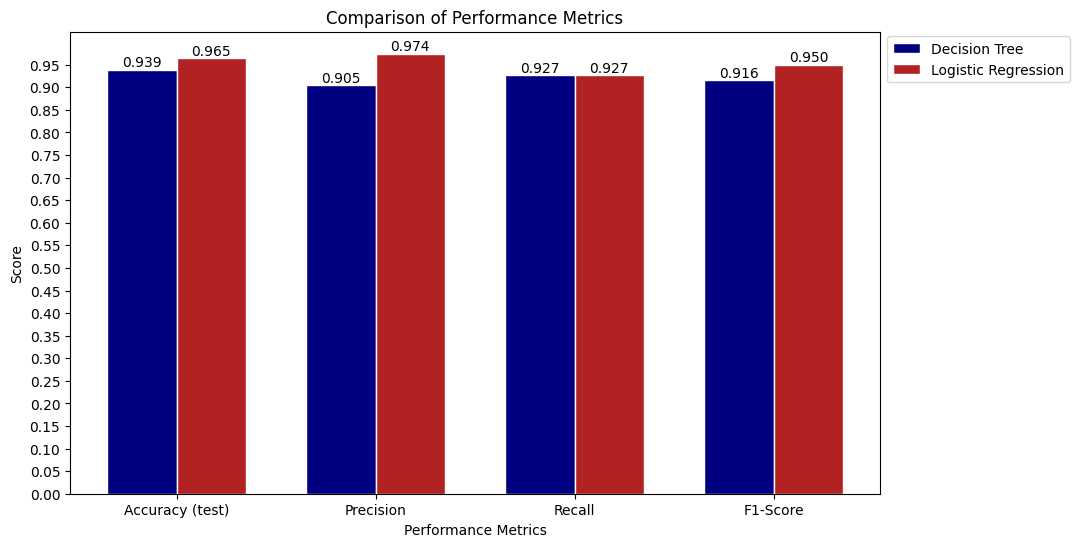

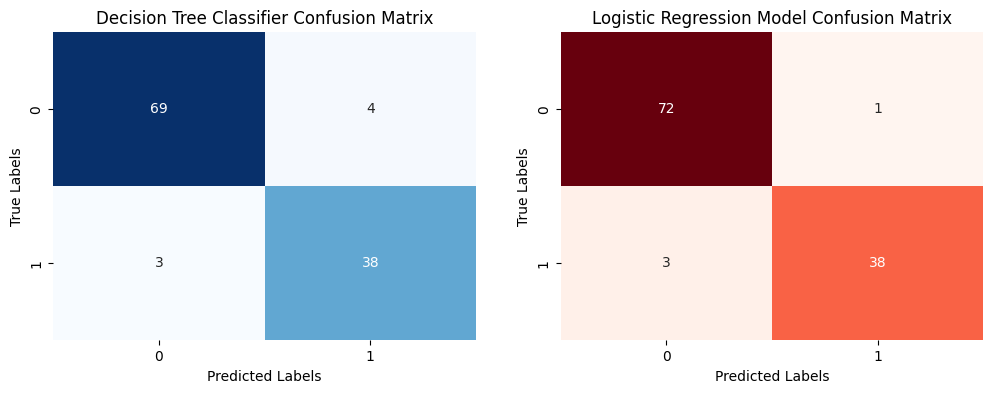

Decision Tree Classifier Metrics:
Accuracy: 93.8596%
Precision: 90.4762%
Recall: 92.6829%
F1-Score: 91.5663%

Logistic Regression Model Metrics:
Accuracy: 96.4912%
Precision: 97.4359%
Recall: 92.6829%
F1-Score: 95.0000%



In [4]:
# 1.1.3
# importing metrics packages
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# a function returning a list of the performance metrics of a model based on its predicted testing data
def get_metrics(actual, predicted):
    return [accuracy_score(actual, predicted), 
            precision_score(actual, predicted, pos_label='M'), 
            recall_score(actual, predicted, pos_label='M'),
            f1_score(actual, predicted, pos_label='M')]

# store the confusion matrix of each model
dt_cm = confusion_matrix(y_te, dt_yp)
lr_cm = confusion_matrix(y_te, lr_yp)

# make a list of the metrics for plotting below
metrics = ['Accuracy (test)', 'Precision', 'Recall', 'F1-Score']
# use the function above to get the performance metrics of each model
lr_scores = get_metrics(y_te, lr_yp)
dt_scores = get_metrics(y_te, dt_yp)

# create a bar chart comparing the performance metrics of the two models
bar_width = 0.35
# set the x positions of the bars
r1 = range(len(metrics))
r2 = [x + bar_width for x in r1]
# plot the bar chart
plt.figure(figsize=(12,6))
plt.bar(r1, dt_scores, color='navy', width=bar_width, edgecolor='white', label='Decision Tree')
plt.bar(r2, lr_scores, color='firebrick', width=bar_width, edgecolor='white', label='Logistic Regression')
plt.xlabel('Performance Metrics')
plt.ylabel('Score')
plt.title('Comparison of Performance Metrics')
# label the x axis with the metric titles
plt.xticks([r + bar_width/2 for r in range(len(metrics))], metrics)
plt.yticks(np.arange(0,1,0.05))
# move the legend outside the plot, more aesthetic
plt.legend(loc='center left', bbox_to_anchor=(1, 0.94))
# Adjust the layout to accommodate the legend
plt.subplots_adjust(right=0.8)

# Add scores as annotations to the bars
for i, score in enumerate(dt_scores):
    plt.text(i, score, f'{score:.3f}', ha='center', va='bottom', color='black')
for i, score in enumerate(lr_scores):
    plt.text(i + bar_width, score, f'{score:.3f}', ha='center', va='bottom', color='black')
plt.show()

# Create a figure and axes to plot the confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Create a heatmap of the confusion matrix for the decision tree classifier
sns.heatmap(dt_cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")
axes[0].set_title("Decision Tree Classifier Confusion Matrix")

# creating a heatmap for the logistic regressor confusion matrix
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Reds", cbar=False, ax=axes[1])
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")
axes[1].set_title("Logistic Regression Model Confusion Matrix")
plt.show()

# printing the metrics 
print("Decision Tree Classifier Metrics:")
print("Accuracy: {:.4f}%".format(100*dt_scores[0]))
print("Precision: {:.4f}%".format(100*dt_scores[1]))
print("Recall: {:.4f}%".format(100*dt_scores[2]))
print("F1-Score: {:.4f}%\n".format(100*dt_scores[3])) 
print("Logistic Regression Model Metrics:")
print("Accuracy: {:.4f}%".format(100*lr_scores[0]))
print("Precision: {:.4f}%".format(100*lr_scores[1]))
print("Recall: {:.4f}%".format(100*lr_scores[2]))
print("F1-Score: {:.4f}%\n".format(100*lr_scores[3]))

## Task 2 

## 2.0 Discussion of Features and their Impact on Classification of Tumour Data

A logistic regression model stores the feature 'coefficients' and a decision tree classifier stores the 'importances', both values indicating the chance a feature has to influence the prediction of the target value. A higher value for either represents the feature's influence on the classification selection of the model. 

Below we have visualised the distribution of importance of the features for both the logistic regression model and decision tree classifier. The feature importance is relatively evenly distributed across the seven features used by the logistic regression model, with 'radius_mean' and 'concavity_mean' the most 'important' with coefficients equal to 28.5% and 18.2% of the total feature importance, respectively. 

As for the decision tree, the distribution is less balanced, with 'radius_mean' appearing to dominate the feature importance, with a value equal to 72% of the total. There are also two features with a feature importance of zero, 'symmetry_mean', 'fractal dimension mean' and 'compactness_mean', indicating they have no impact on the classification at all. Across the two models, concavity_mean and radius_mean remain the two most important features, while symmetry mean, compactness mean and fractal dimension mean represent a very small contribution across both models.

These importances would indicate the radius or size, along with the concavity of the cell nuclei of tumour tissue has a strong correlation with its diagnosis. 

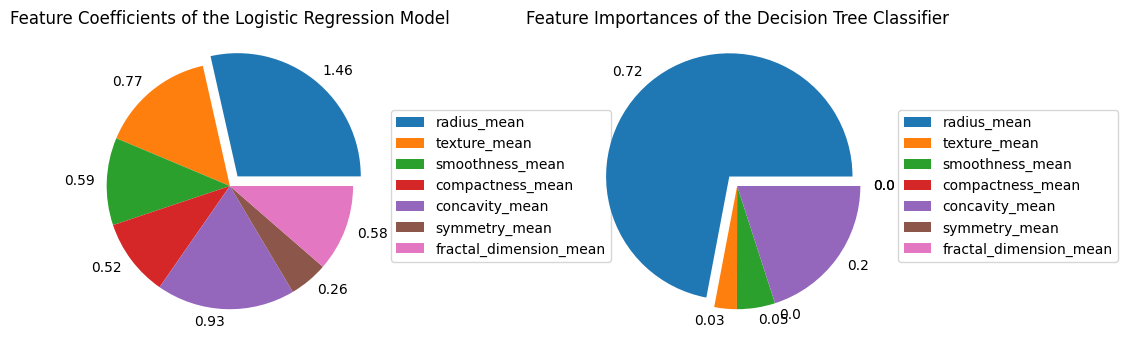

Feature Coefficients for the Logistic Regression Model
	radius_mean: 1.458 -> 28.5%
	texture_mean: 0.774 -> 15.1%
	smoothness_mean: 0.587 -> 11.5%
	compactness_mean: 0.521 -> 10.2%
	concavity_mean: 0.931 -> 18.2%
	symmetry_mean: 0.260 -> 5.1%
	fractal_dimension_mean: 0.582 -> 11.4%

Feature Importances for the Decision Tree Classifier
	radius_mean: 0.720 -> 72.0%
	texture_mean: 0.030 -> 3.0%
	smoothness_mean: 0.050 -> 5.0%
	compactness_mean: 0.000 -> 0.0%
	concavity_mean: 0.200 -> 20.0%
	symmetry_mean: 0.000 -> 0.0%
	fractal_dimension_mean: 0.000 -> 0.0%


In [5]:
# 1.2.0
# extract coefficients/importances and feature names for each feature of each model
coefficients = np.abs(lr_f.coef_[0])
importances = dt_f.feature_importances_
feature_names = np.array(x.columns)  # Replace with your actual feature names
# get a sum for calculating percentage importance for each feature
cosum = sum(coefficients)
isum = sum(importances)

# plot pie charts of the feature importances/coefficients
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].pie(coefficients, labels=np.round(coefficients,2), explode=[0.1,0,0,0,0,0,0])
axes[0].set_title("Feature Coefficients of the Logistic Regression Model")
axes[0].legend(feature_names, loc='center left', bbox_to_anchor=(1, 0.5))
axes[1].pie(importances, labels=np.round(importances,2), explode=[0.1,0,0,0,0,0,0])
axes[1].set_title("Feature Importances of the Decision Tree Classifier")
axes[1].legend(feature_names, loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

# Print the coefficients and importances
print("Feature Coefficients for the Logistic Regression Model")
for feature, coefficient in zip(feature_names, coefficients):
    print("\t{}: {:.3f} -> {:.1f}%".format(feature, coefficient, coefficient*100/cosum))
print("\nFeature Importances for the Decision Tree Classifier")
for feature, importance in zip(feature_names, importances):
    print("\t{}: {:.3f} -> {:.1f}%".format(feature, importance, importance*100/isum))

## Task 3

## 3.0 Principal Component Analysis of the first two Components

Here we perform principle component analysis to combine our original features and find a new set of uncorrelated variables called principle components. Each consecutive component explains a lesser magnitude of variance within the breast cancer dataset. We've limited the PCA to two principal components, the first explaining approximately 41.7% of the variance in the data, and the second, explaining approximately 24.9%. Together, the first two principal components explain approximately 72.7% of the variance within the data.

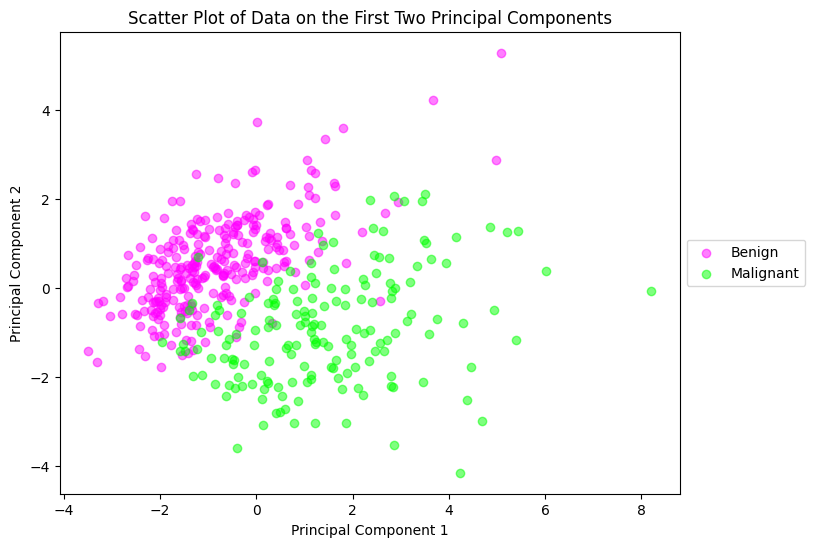

Proportion of Data Variance Explained by First Two Principal Components:
First PC: 47.7778%
Second PC: 24.9424%
Total: 72.7202%


In [6]:
# 1.3.0
# importing packages
from sklearn.decomposition import PCA

# performing PCA
pca = PCA(n_components=2)  # set the number of components to 2
x_pca = pca.fit_transform(x_tr)  # apply PCA transformation
explained_variance_ratio = pca.explained_variance_ratio_  # get explained variance ratio

# Create the scatter plot
plt.figure(figsize=(8,6))
plt.scatter(x_pca[y_tr == 'B', 0], x_pca[y_tr == 'B', 1], label='Benign', color="magenta", alpha=0.5)
plt.scatter(x_pca[y_tr == 'M', 0], x_pca[y_tr == 'M', 1], label='Malignant', color="lime", alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Data on the First Two Principal Components')
# move the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

print("Proportion of Data Variance Explained by First Two Principal Components:")
print("First PC: {:.4f}%".format(explained_variance_ratio[0] * 100))
print("Second PC: {:.4f}%".format(explained_variance_ratio[1] * 100))
print("Total: {:.4f}%".format(100*sum(explained_variance_ratio)))

## Task 4

## 1.4 Biplot of Variable Vectors, Observed Data on the first two Principal Components

We first scale the principal component values to the same scale as the variable vectors. From the plot, we can see the impact of the different features on each principal component. The length of the vectors indicate how much variance they explain, while the angle represents the correlation to the two principal components. compactness_mean is closely correlated with the first principal component, while texture_mean has the closest correlation (though negative) to the second principal component. The vectors aligned at around a 45 degree angle indicate an equal correlation to both of the principal components.

All of our features have a positive correlation to the first principal component, while correlation to the second component varies. texture_mean has the weakest magnitude of impact on the principal components, as it has the shortest arrow. The two blue arrows on the plot represent the components of the radius_mean vector, which are the individual eigenvectors for each of the two components. We can see the radius_mean vector is the product of a second principal component vector of magnitude ~-0.6, and a first principal component vector of magnitude ~0.25. These vectors represent the individual impact the feature has on each of the components. Each of the variable vectors are made up of these two vectors. 

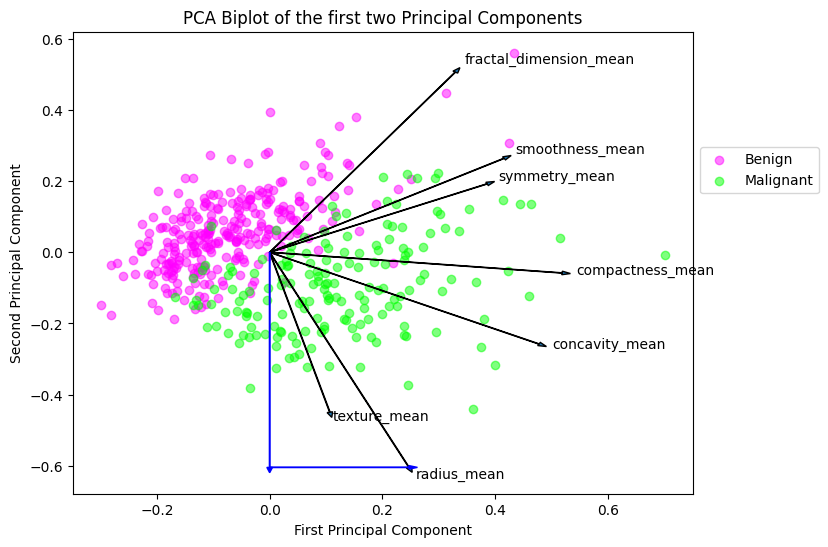

In [7]:
# 1.4.0, 1.5.0
# Find pca components
pca_comp = pca.components_

# seperate the two principal components
PC1 = x_pca[:, 0]
PC2 = x_pca[:, 1]

# get the scale of our principal components
PC1_scale = 1 / (max(PC1) - min(PC1))
PC2_scale = 1 / (max(PC2) - min(PC2))

# replot the graph from above, rescaled to present the variable vectors 
plt.figure(figsize=(8,6))
plt.scatter(x_pca[y_tr == 'B', 0] * PC1_scale, x_pca[y_tr == 'B', 1] * PC2_scale, label='Benign', color="magenta", alpha=0.5)
plt.scatter(x_pca[y_tr == 'M', 0] * PC1_scale, x_pca[y_tr == 'M', 1] * PC2_scale, label='Malignant', color="lime", alpha=0.5)

# plot our variable vectors, the features in the data impacting classification
i = 0
while i < len(pca_comp[0]):
    plt.arrow(0, 0, pca_comp[0, i], pca_comp[1, i], head_width=0.01)
    plt.text(pca_comp[0, i] * 1.05, pca_comp[1, i] * 1.05, x.columns[i])
    i += 1

# plot constructing vectors of the radius mean vector to demonstrate magnitude
plt.arrow(0, 0, 0, pca_comp[1,0], head_width=0.01, color='blue')
plt.arrow(0, pca_comp[1,0], pca_comp[0,0], 0, head_width=0.01, color='blue')

# detail the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.title("PCA Biplot of the first two Principal Components")
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

## Task 5

## 1.5 Exploring the Relevance of Features to the Target Data

Along with the plot above, a quick pie chart shows the distribution of impact the seven features have on the principal components. We can see there is a relatively even spread of eigenvector magnitudes across all of our components, however these vectors vary in direction and therefore vary in individual impact on the two principal components. As for relation to the classification of tumour status, we can imagine a rough decision boundary splitting our benign and malignant datapoints at a 45 degree angle running from the bottom left to the top right of the graph. This means that malignant tumours will generally have a higher first principal component value, and a lower second principal component value, and vice versa for the benign tumour entries. 

Comparing the below pie chart with our results from task two, we can see our eigenvalues are roughly similar to the coefficients from the logistic regression model, reducing the importance of the more dominant features and increasing the importance of the less dominant features to yield a more even spread. The decision tree's importance values were quite different however, as 75% of the importance was placed on the radius_mean feature. The PCA eigenvalues are a more even distribution of impact than either of the models in task two. 

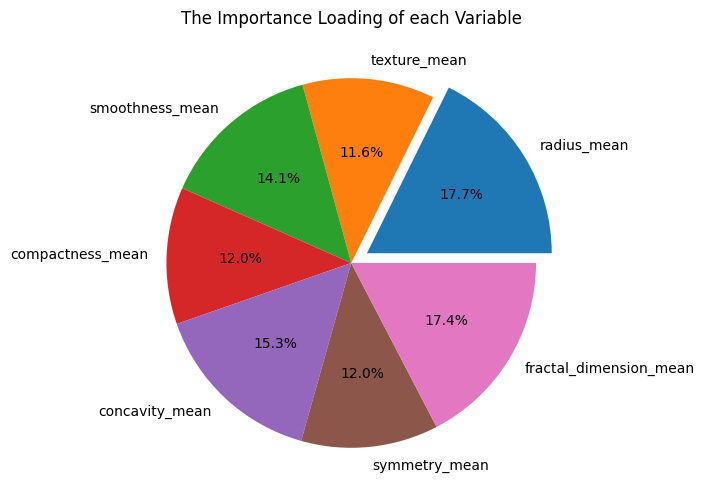

In [8]:
# 1.5.1
# get the loading of impact on the principal components
loadings = pca.components_

# Calculate the magnitude of loadings
loadings_magnitude = np.abs(loadings)

# Calculate the sum of loadings for each principal component
loadings_sum = np.sum(loadings_magnitude, axis=0)

# Calculate the percentage of loadings for each feature
loadings_percentage = (loadings_sum / np.sum(loadings_sum)) * 100

# Create a pie chart of loadings percentage
plt.figure(figsize=(8, 6))
plt.pie(loadings_percentage, labels=x.columns, autopct='%1.1f%%', explode=[0.1,0,0,0,0,0,0])
plt.title('The Importance Loading of each Variable')
plt.show()

## Task 6 

## 1.6 Determining the Number of Components Needed to Retain 95% Explained Variance

By setting 'n_components' to 0.95, we determine the number of required components to retain a 95% explained variance is five, and so the dimension of the projected dataset is 569x5, if we recombine the training and testing datasets (that is, five features, and 569 tumour data entries) Five features actually retains approximately 97.53% of the explained variance, but four components does not meet the 95% requirement, so we select five. 

Repeating task one with the five remaining features after performing the PCA, our default regressor performs marginally worse than the original default regressor, a reduction ~0.2% on the training data, and ~0.9% on the testing data. Performing fine tuning on the PCA data, we interestingly return the model performance to the same accuracy scores (for both the training and testing data) as with the original fine tuned model. The two models also share the same precision, recall and f1-scores. 

Looking at the confusion matrices of the default and fine-tuned PCA models, we can see the default incorrectly classifies five out of 114 entries, while the fine-tuned model only incorrectly classifies four. 


Retaining 95% Explained Variance:
 Number of components: 5
 Yielding explained variance of: 97.53%

Accuracy Scores of the Default Logistic Regressor:
 Training: 93.41%
 Testing: 95.61%

Accuracy Scores after Fine Tuning:
 Best parameters:  {'C': 0.1, 'penalty': 'l2'}
 Training: 93.85%
 Testing: 96.49%

Logistic Regression Model Metrics:
 Precision: 97.44%
 Recall: 92.68%
 F1-Score: 95.00%

The dimension of the projected data: (114, 5)


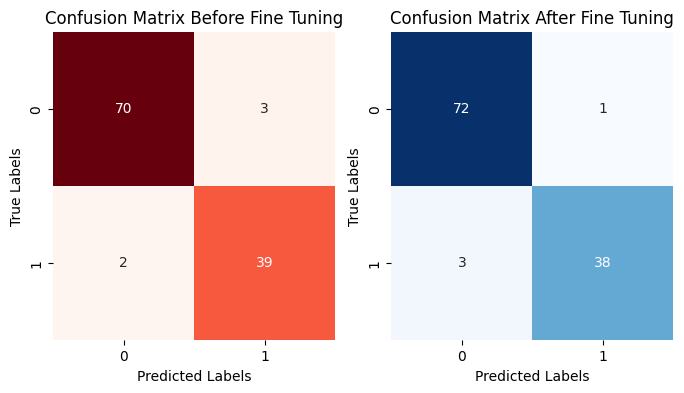

In [9]:
# 1.6.0
# PCA to retain 95% of the explained variance
pca95 = PCA(n_components=0.95)
x_tr_pca = pca95.fit_transform(x_tr)
x_te_pca = pca95.transform(x_te)

# print the number of components required along with the total explained variance
print("Retaining 95% Explained Variance:")
print(" Number of components:", len(x_tr_pca[0]))
print(" Yielding explained variance of: {:.2f}%\n".format(sum(pca95.explained_variance_ratio_)*100))

# repeating task 1 (1.1) on these features
# training default logistic regression model
lr_pca = LogisticRegression(random_state=random_state, solver='liblinear')
lr_pca.fit(x_tr_pca, y_tr)

# get accuracy scores on the training and testing set
lr_pca_yte = lr_pca.predict(x_te_pca)
lr_pca_ytr = lr_pca.predict(x_tr_pca)

# print the accuracy scores
print("Accuracy Scores of the Default Logistic Regressor:")
print(" Training: {:.2f}%".format(100*accuracy_score(y_tr, lr_pca_ytr)))
print(" Testing: {:.2f}%".format(100*accuracy_score(y_te, lr_pca_yte)))

# define a parameter grid for the grid search
parameter_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}

# constructing new logistic regressor
lr_pca_f = LogisticRegression(random_state=random_state, solver='liblinear')

# perform the grid search
grid_search = GridSearchCV(estimator=lr_pca_f, param_grid=parameter_grid, cv=3)
grid_search.fit(x_tr_pca, y_tr)

# get the best parameters for the logistic regression model from the grid search
best_params_95 = grid_search.best_params_
print("\nAccuracy Scores after Fine Tuning:")
print(" Best parameters: ", best_params_95)

# train the model with the best params
lr_pca_f = LogisticRegression(random_state=random_state, **best_params_95)
lr_pca_f.fit(x_tr_pca, y_tr)

# get the accuracy scores of the fine tuned model
lr_pca_ft_ytr = lr_pca_f.predict(x_tr_pca)
print(" Training: {:.2f}%".format(100*accuracy_score(y_tr, lr_pca_ft_ytr)))
lr_pca_ft_yte = lr_pca_f.predict(x_te_pca)
print(" Testing: {:.2f}%".format(100*accuracy_score(y_te, lr_pca_ft_yte)))

# get the metrics of the fine tuned model
ft_metrics = get_metrics(y_te, lr_pca_ft_yte)
print("\nLogistic Regression Model Metrics:")
print(" Precision: {:.2f}%".format(100*ft_metrics[1]))
print(" Recall: {:.2f}%".format(100*ft_metrics[2]))
print(" F1-Score: {:.2f}%".format(100*ft_metrics[3]))

# get the dimension or 'shape' of the projected dataset
print("\nThe dimension of the projected data:", x_te_pca.shape)

# get confusion matrices 
lr_pca_cm = confusion_matrix(y_te, lr_pca_yte)
lr_pca_cm_ft = confusion_matrix(y_te, lr_pca_ft_yte)

# plot confusion matrices side by side
fig, axes = plt.subplots(1,2,figsize=(8,4))
# for the default model
sns.heatmap(lr_pca_cm, annot=True, fmt="d", cmap="Reds", cbar=False, ax=axes[0])
axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("True Labels")
axes[0].set_title("Confusion Matrix Before Fine Tuning")
# for the fine tuned model
sns.heatmap(lr_pca_cm_ft, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[1])
axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("True Labels")
axes[1].set_title("Confusion Matrix After Fine Tuning")
plt.show()

# Section 2 - A clustering analysis on airlines safety records

## Task 1

## 2.1 K-Means Clustering and Silhoutte Scores

Silhoutte score indicates the resulting quality of clusters generated by K-Means clustering. The silhoutte score takes into account two factors, cohesion or how precise datapoints are in the same cluster, and separation or how well sepearated different clusters in the data are. The silhoutte score value varies from -1 to 1, where a value closer to 1 means points are more likely to be assigned to their correct cluster. 

Scaling is discussed in part # 2.3.0.

From the graph, we observe the highest silhoutte score at K=2, with a value of approximately 0.465. As the K value increases, the corresponding silhoutte score value decreases. We finish at K=8, where the silhoutte score value is just above 0.275. We select K=2 as our value, as it yields the largest silhoutte score, and makes the most sense in the context of airline safety - two groups, 0 or 1, safe or unsafe, to fly. There are obviously other options for K values to go further in depth on safety analysis, but I believe the purpose of this tool will be to decide whether or not an airline is 'unsafe' to fly, so people scared to fly can reassure themselves by selecting a 'safe' airline, so K=2 is a decent choice for now.

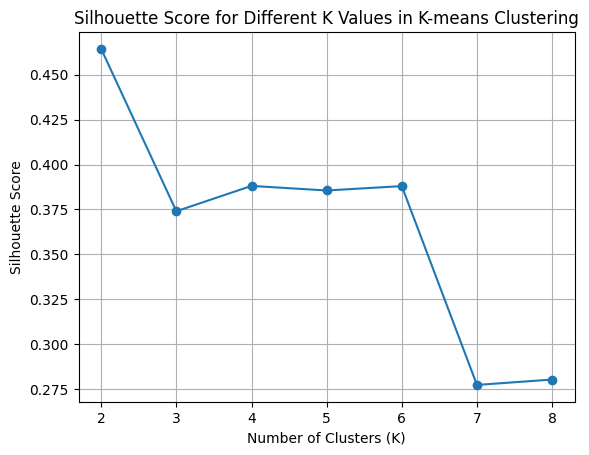

In [10]:
# 2.1.0
# importing packages
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set the random state for reproducibility
random_state = 5508

# read in the data
airline_safety = pd.read_csv("airline-safety.csv")

# split the data into feature and target, removing the non numerical target from the feature variables
x = airline_safety.drop("airline", axis=1)
y = airline_safety["airline"]

# scaling the data so each feature has equal importance
scaler = StandardScaler()
x_s = scaler.fit_transform(x)
x_s = pd.DataFrame(x_s, columns=x.columns)

# Range of K values to test
k_values = range(2, 9)

# Initialize an empty list to store silhouette scores
silhouette_scores = []

# Perform K-means clustering for each K value and calculate the silhouette score
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    labels = kmeans.fit_predict(x_s)
    silhouette_scores.append(silhouette_score(x_s, labels))

# Plot the silhouette scores
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K Values in K-means Clustering')
plt.grid(True)
plt.show()

## Task 2

## 2.2 Applying K-Means Clustering

performing k-means clustering analysis on the airline safety data with k=2, we establish that there are two relatively distinct groups. The first, cluster 0, is the 'safe' group, with lower average incidents, fatal accidents, and fatalities than cluster 1, or the 'unsafe' group. This is true across both time periods, as we expect airline safety to have improved from 1984 to 2000 through the advancement of technology and airline personnel training. We can view the centroids of the clusters on the graph as 'X' markers in their corresponding colours. There are some big outliers in the 'unsafe' cluster, which can be explained as smaller, cheaper airlines flying in remote locations, more likely to have accidents, incidents and consequently, fatalities.

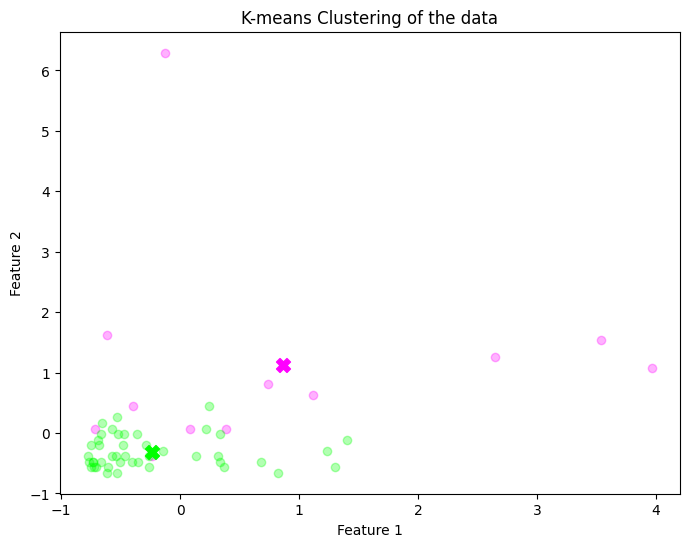

Cluster 0 Safety Record (Averages)
Group Size:  12
1985-1999
	Incidents: 19.50
	Fatal Accidents: 5.92
	Fatalities: 199.17
2000-2014
	Incidents: 9.42
	Fatal Accidents: 1.92
	Fatalities: 183.00

Cluster 1 Safety Record (Averages)
Group Size:  44
1985-1999
	Incidents: 3.82
	Fatal Accidents: 1.16
	Fatalities: 88.75
2000-2014
	Incidents: 2.68
	Fatal Accidents: 0.32
	Fatalities: 20.75



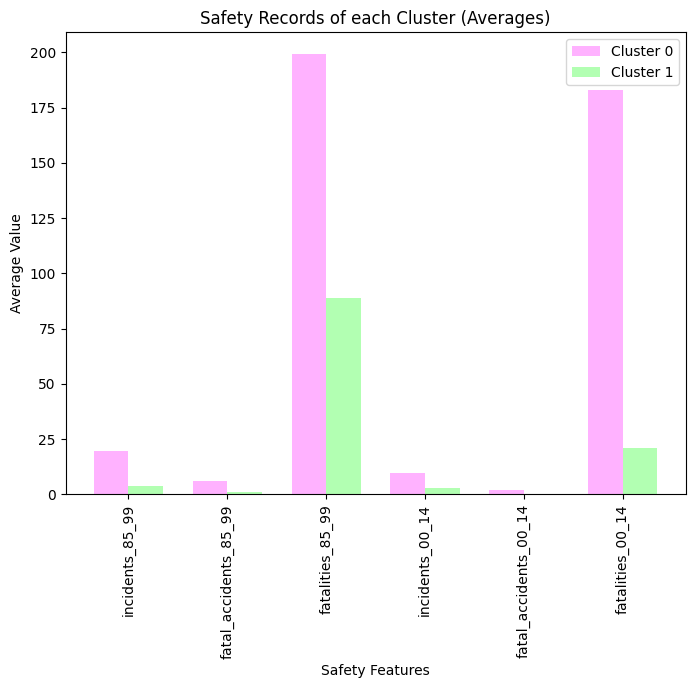

In [11]:
# 2.2.0
# function for getting the average values for each cluster and returning them as an array
def get_safety_record(cluster, data):
    
    # the safety record to be returned
    safety_record = []
    
    # get all the rows belonging to this cluster
    cluster_data = data[data['Cluster'] == cluster]
    
    # print the size of the cluster
    print("Cluster {} Safety Record (Averages)".format(cluster))
    print("Group Size: ", len(cluster_data))
    
    # print and store the average values of features in the cluster
    print("1985-1999")
    safety_record.append(cluster_data["incidents_85_99"].mean())
    print("\tIncidents: {:.2f}".format(safety_record[0]))
    safety_record.append(cluster_data["fatal_accidents_85_99"].mean())
    print("\tFatal Accidents: {:.2f}".format(safety_record[1]))  
    safety_record.append(cluster_data["fatalities_85_99"].mean())
    print("\tFatalities: {:.2f}".format(safety_record[2]))
    print("2000-2014")
    safety_record.append(cluster_data["incidents_00_14"].mean())
    print("\tIncidents: {:.2f}".format(safety_record[3]))
    safety_record.append(cluster_data["fatal_accidents_00_14"].mean())
    print("\tFatal Accidents: {:.2f}".format(safety_record[4]))  
    safety_record.append(cluster_data["fatalities_00_14"].mean())
    print("\tFatalities: {:.2f}\n".format(safety_record[5]))
    
    return safety_record


# Set the optimal value of K obtained in Task 1
K = 2

# Initialize and fit the K-means clustering model
kmeans = KMeans(n_clusters=K, random_state=random_state, n_init=10)
kmeans.fit(x_s)

# Get the cluster labels for each data point
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Plotting the data points with different colors for each cluster
plt.figure(figsize=(8,6))
plt.scatter(x_s.values[labels==0, 0], x_s.values[labels==0, 1], c='magenta', alpha=0.3)
plt.scatter(x_s.values[labels==1, 0], x_s.values[labels==1, 1], c='lime', alpha=0.3)
# Plotting the centroid positions
plt.scatter(centroids[0, 0], centroids[0, 1], marker='X', c='magenta', s=100)
plt.scatter(centroids[1, 0], centroids[1, 1], marker='X', c='lime', s=100)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering of the data')
plt.show()

# Create a DataFrame with the original data and cluster labels
x_l = x.copy()
x_l['Cluster'] = labels

# a feature list for xticks on a plot
record_features = airline_safety.drop(["airline", "avail_seat_km_per_week"], axis=1).columns
# calling the above function to get the safety values 
safety_record0 = get_safety_record(0, x_l)
safety_record1 = get_safety_record(1, x_l)

# plotting the safety record values of the two groups
bar_width = 0.35
xpos = np.arange(len(record_features))
plt.figure(figsize=(8, 6))
plt.bar(xpos-bar_width/2, safety_record0, bar_width, label='Cluster 0', color="magenta", alpha=0.3)
plt.bar(xpos+bar_width/2, safety_record1, bar_width, label='Cluster 1', color="lime", alpha=0.3)    
plt.xticks(xpos, record_features, rotation="vertical")
plt.xlabel("Safety Features")
plt.ylabel("Average Value")
plt.title("Safety Records of each Cluster (Averages)")
plt.legend()
plt.show()

## Task 3 

## 2.3 Scaling on the Airline Data before K-Means Clustering Analysis

The airline safety dataset contains a majority of relatively small values (0-~250) for all features except one, the avail_seat_km_per_week feature. This variable contains consistently large numbers that may skew the clustering results. We want to keep this feature as it is important for measuring the number of accidents per flight, a decent estimator for the actual safety of each airline. Scaling will help to equalise the feature influence across all of the variables, potentially improving cluster seperation, and therefore performance of the algorithm. Scaling will also improve the convergence speed of the clustering algorithm, and remove outliers from the data. 

## Task 4 
 
## 2.4 K-Means Cluster Analysis and Comparison of Data from the two Time Periods
 
Splitting the data into the two time period categories, we perform a k-means cluster analysis using very similar code to task three, on both the 1985 to 1999 and 2000 to 2014 data. We can see the split for both time periods is similar to split for the entire dataset, but the newer data yields 10 unsafe airlines, while the older period yields seven. The primary contributors to the selection appear to be the 'fatalities' features from the two time periods. It can be argued that in the context of airplane safety, fatality rate is probably the most important factor, so this works nicely.

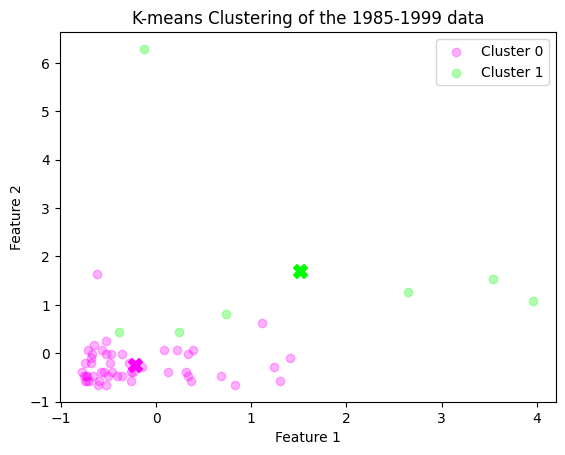

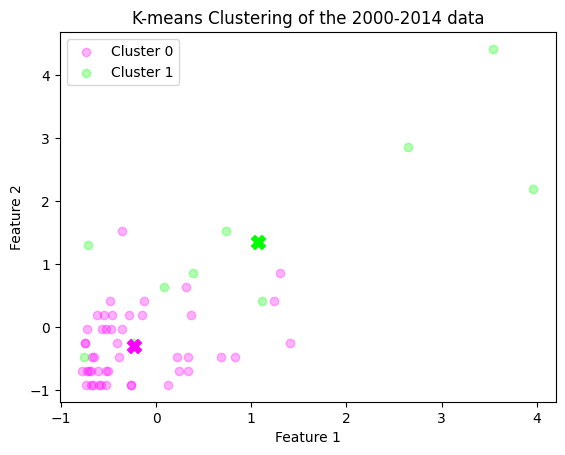

1985-1999 Data:
Cluster 0 Safety Record (Averages)
Group Size:  49
1985-1999
	Incidents: 4.53
	Fatal Accidents: 1.33
	Fatalities: 84.82
2000-2014
	Incidents: 3.18
	Fatal Accidents: 0.53
	Fatalities: 44.84

Cluster 1 Safety Record (Averages)
Group Size:  7
1985-1999
	Incidents: 25.71
	Fatal Accidents: 8.14
	Fatalities: 305.57
2000-2014
	Incidents: 10.71
	Fatal Accidents: 1.57
	Fatalities: 130.29

2000-2014 Data:
Cluster 0 Safety Record (Averages)
Group Size:  46
1985-1999
	Incidents: 6.07
	Fatal Accidents: 1.65
	Fatalities: 102.93
2000-2014
	Incidents: 2.80
	Fatal Accidents: 0.35
	Fatalities: 22.50

Cluster 1 Safety Record (Averages)
Group Size:  10
1985-1999
	Incidents: 12.30
	Fatal Accidents: 4.60
	Fatalities: 156.00
2000-2014
	Incidents: 10.20
	Fatal Accidents: 2.10
	Fatalities: 207.40



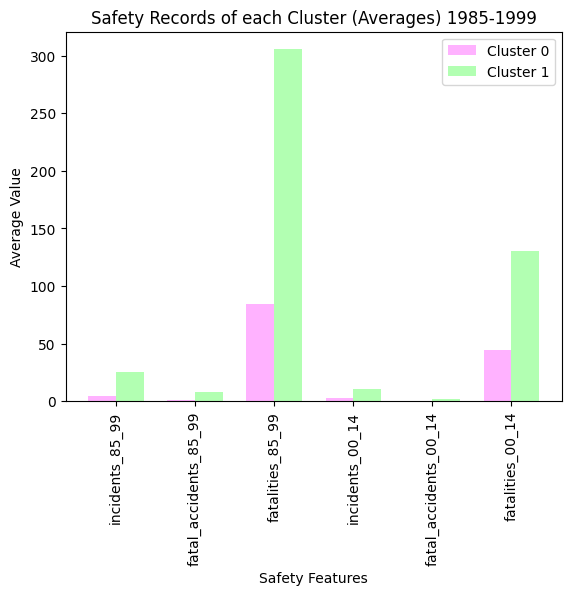

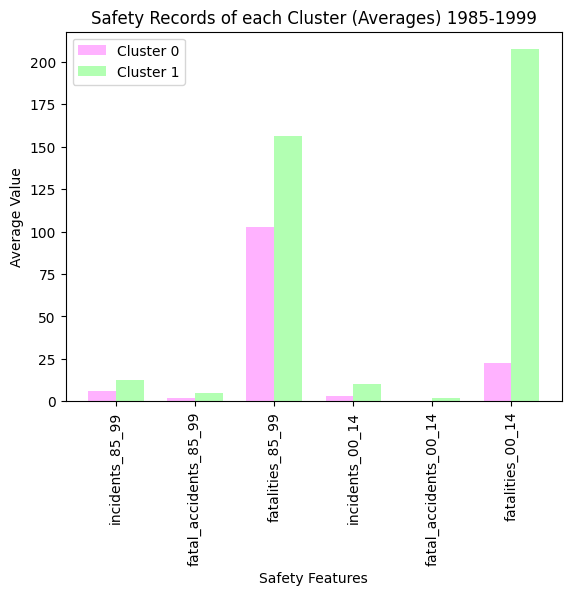

In [12]:
# 2.4.0
# creating two seperate datasets, one for each time period
x85 = x_s.drop(["incidents_00_14", "fatal_accidents_00_14", "fatalities_00_14"], axis=1).values
x00 = x_s.drop(["incidents_85_99", "fatal_accidents_85_99", "fatalities_85_99"], axis=1).values

# two cluster analyses, one for each time period
kmeans85 = KMeans(n_clusters=K, random_state=random_state, n_init=10)
kmeans00 = KMeans(n_clusters=K, random_state=random_state, n_init=10)
kmeans85.fit(x85)
kmeans00.fit(x00)

# get the labels and cluster centroid coordinates
labels85 = kmeans85.labels_
labels00 = kmeans00.labels_
centroid85 = kmeans85.cluster_centers_
centroid00 = kmeans00.cluster_centers_

# make new frames with the labels included 
x_l85 = x.copy()
x_l85['Cluster'] = labels85
x_l00 = x.copy()
x_l00['Cluster'] = labels00

# Plotting the data points with different colors for each cluster for the 1985-1999 data
plt.scatter(x85[labels85==0, 0], x85[labels85==0, 1], c='magenta', alpha=0.3, label="Cluster 0")
plt.scatter(x85[labels85==1, 0], x85[labels85==1, 1], c='lime', alpha=0.3, label="Cluster 1")
# Plotting the centroid positions
plt.scatter(centroid85[0, 0], centroid85[0, 1], marker='X', c='magenta', s=100)
plt.scatter(centroid85[1, 0], centroid85[1, 1], marker='X', c='lime', s=100)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering of the 1985-1999 data')
plt.legend()
plt.show()

# Plotting the same as above for the 2000-2014 data
plt.scatter(x00[labels00==0, 0], x00[labels00==0, 1], c='magenta', alpha=0.3, label="Cluster 0")
plt.scatter(x00[labels00==1, 0], x00[labels00==1, 1], c='lime', alpha=0.3, label="Cluster 1")
# Plotting the centroid positions
plt.scatter(centroid00[0, 0], centroid00[0, 1], marker='X', c='magenta', s=100)
plt.scatter(centroid00[1, 0], centroid00[1, 1], marker='X', c='lime', s=100)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering of the 2000-2014 data')
plt.legend()
plt.show()

# plotting the safety record values of the two groups for each cluster
bar_width = 0.35
xpos = np.arange(len(record_features))
print("1985-1999 Data:")
# fill the safety records for the two time periods and their two clusters
safety_record0 = get_safety_record(0, x_l85)
safety_record1 = get_safety_record(1, x_l85)
print("2000-2014 Data:")
safety_record2 = get_safety_record(0, x_l00)
safety_record3 = get_safety_record(1, x_l00)
plt.bar(xpos-bar_width/2, safety_record0, bar_width, label='Cluster 0', color="magenta", alpha=0.3)
plt.bar(xpos+bar_width/2, safety_record1, bar_width, label='Cluster 1', color="lime", alpha=0.3)    
plt.xticks(xpos, record_features, rotation="vertical")
plt.xlabel("Safety Features")
plt.ylabel("Average Value")
plt.title("Safety Records of each Cluster (Averages) 1985-1999")
plt.legend()
plt.show()

plt.bar(xpos-bar_width/2, safety_record2, bar_width, label='Cluster 0', color="magenta", alpha=0.3)
plt.bar(xpos+bar_width/2, safety_record3, bar_width, label='Cluster 1', color="lime", alpha=0.3)    
plt.xticks(xpos, record_features, rotation="vertical")
plt.xlabel("Safety Features")
plt.ylabel("Average Value")
plt.title("Safety Records of each Cluster (Averages) 1985-1999")
plt.legend()
plt.show()

## Task 5

## 2.5 K-Means Cluster Analysis of the Safety Improvement of Airlines from 1985 to 1999 and 2000 to 2014

The ratio of each safety record obtained by dividing the 2000-2014 data by the 1985-1999 data gives us a value for how the safety of the airline has changed between these time periods. A value of less than one for any of the features indicates the airline has improved on this metric, and less incidents/accidents/fatalities are occuring per person per kilometre flown by the airline. A value above one means the airline has decreased in safety performance since 1985-99. This is not what an airline would want as flying should be getting safer as technology advances. 

Our K-means clustering analysis gives us two groups, one including the majority of airlines that have improved since 1999, and the other minority of airlines that havent, with feature values above one. These are likely small airlines that have had one terrible crash. 


Group 0 Data: 
 Group Size:  37
 Average Incident Ratio: 0.68
 Average Fatal Accident Ratio: 0.21
 Average Fatality Ratio: 0.42

Group 1 Data: 
 Group Size:  2
 Average Incident Ratio: 1.00
 Average Fatal Accident Ratio: 1.25
 Average Fatality Ratio: 14.81


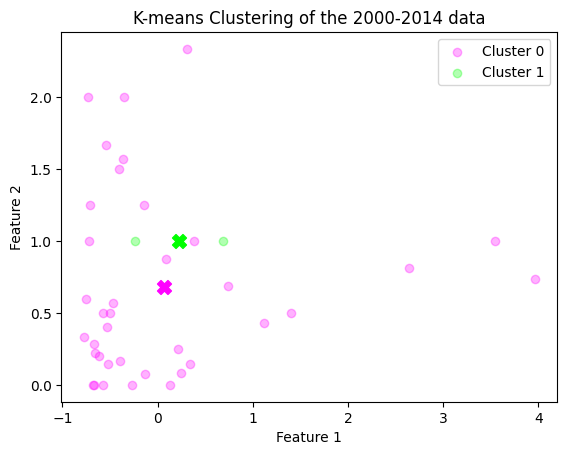

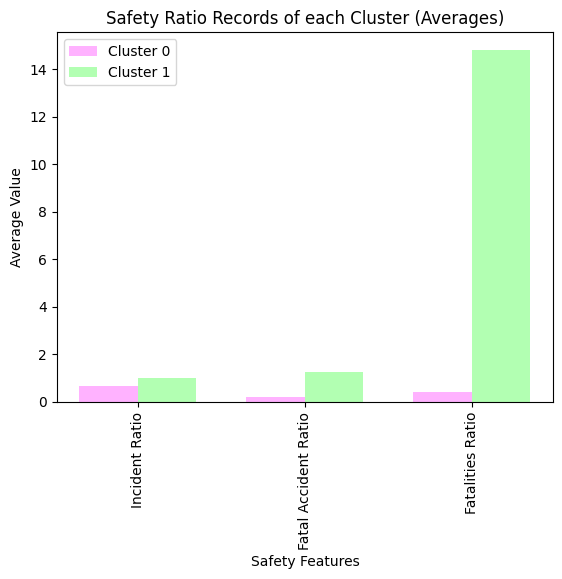

In [13]:
# 2.5.0
# creating a new dataframe for the ratio values of each feature
x_r = pd.DataFrame()
x_r["avail_seat_km_per_week"] = x_s["avail_seat_km_per_week"]
x_r["Incidents"] = x["incidents_00_14"] / x["incidents_85_99"] 
x_r["Fatal Accidents"] = x["fatal_accidents_00_14"] / x["fatal_accidents_85_99"]
x_r["Fatalities"] = x["fatalities_00_14"] / x["fatalities_85_99"]

# Remove rows with null or infinite values
x_r = x_r.replace([np.inf, -np.inf], np.nan).dropna(how='any')

x_r_v = x_r.values

kmeans_r = KMeans(n_clusters=K, random_state=random_state, n_init=10)
kmeans_r.fit(x_r_v)

labels_r = kmeans_r.labels_
centroids_r = kmeans_r.cluster_centers_

x_rf = x_r.copy()
x_rf['Cluster'] = labels_r

# build safety record
safety_record = []
feature_record = ['Incident Ratio', 'Fatal Accident Ratio', 'Fatalities Ratio']

# quick loop to organise safety record for a bar chart
i=0
while i < 2:
    cluster_data = x_rf[x_rf['Cluster'] == i]
    print("\nGroup {} Data: ".format(i))
    print(" Group Size: ", len(cluster_data))
    safety_record.append(cluster_data["Incidents"].mean())
    print(" Average Incident Ratio: {:.2f}".format(cluster_data["Incidents"].mean()))
    safety_record.append(cluster_data["Fatal Accidents"].mean())
    print(" Average Fatal Accident Ratio: {:.2f}".format(cluster_data["Fatal Accidents"].mean()))
    safety_record.append(cluster_data["Fatalities"].mean())
    print(" Average Fatality Ratio: {:.2f}".format(cluster_data["Fatalities"].mean()))
    
    if i == 0:
        safety_record0 = safety_record
    else:
        safety_record1 = safety_record
    safety_record = []
    i += 1

# Plotting the data points with different colors for each cluster
plt.scatter(x_r_v[labels_r==0, 0], x_r_v[labels_r==0, 1], c='magenta', alpha=0.3, label="Cluster 0")
plt.scatter(x_r_v[labels_r==1, 0], x_r_v[labels_r==1, 1], c='lime', alpha=0.3, label="Cluster 1")
# Plotting the centroid positions
plt.scatter(centroids_r[0, 0], centroids_r[0, 1], marker='X', c='magenta', s=100)
plt.scatter(centroids_r[1, 0], centroids_r[1, 1], marker='X', c='lime', s=100)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering of the 2000-2014 data')
plt.legend()
plt.show()

xpos = np.arange(len(feature_record))
plt.bar(xpos-bar_width/2, safety_record0, bar_width, label='Cluster 0', color="magenta", alpha=0.3)
plt.bar(xpos+bar_width/2, safety_record1, bar_width, label='Cluster 1', color="lime", alpha=0.3)    
plt.xticks(xpos, feature_record, rotation="vertical")
plt.xlabel("Safety Features")
plt.ylabel("Average Value")
plt.title("Safety Ratio Records of each Cluster (Averages)")
plt.legend()
plt.show()

# Section 3 - Clustering Analysis on US Arrests Data

## Task 1

## 3.1 Performing Hierarchical Clustering 

After reading in the US Arrests data, we first remove the 'State' feature as it is essentially an ID column and will not have any impact on the clustering algorithm. We then perform hierarchical clustering using agglomerative clustering making use of 'complete linkage', which has the algorithm take the distance from one side of the cluster to the other and using that value to calculate the 'dissimilarity' between the clusters. The algorithm starts by taking the first datapoint and finding the closest nearby datapoint and grouping them into a cluster. The algorithm then finds the 'next' closest cluster or datapoint, and merges the two together into one big cluster. This process continues until the specified number of clusters remains, in this case, three clusters. 

We are using euclidean distance as the distance between our datapoints, which simply takes a straight line between two points, measures the length of the line, and uses this value as a measure of dissimilarity. On the dendrogram, we see the first of the three main clusters emerging at a distance of around 105. The three clusters are all similar in size, and the distance before the data continues to combine into bigger clusters is large, indicating the three clusters are well seperated or have good dissimilarity, and the three groups form quite naturally. 

Cluster 0 contains 16 states, cluster 1 contains 14, and cluster 2 contains 20, a relatively even distribution of datapoints between the three clusters. The shape and branch lengths of the three clusters are similar, and decently compact, indicating the similarity of data across states within their clusters. 

As for the average values for each cluster, it appears the average urban population value trends to having an approximately linear relationship with murder and assault, however the rape value does not quite follow suit, though the lowest average rape value corresponds to the lowest average urban pop value. The linear relationship could be explained by the denser states containing higher urban populations, where people interact more and there is less accountability than in country towns where people know each other, and such more assaults and murders occur. 

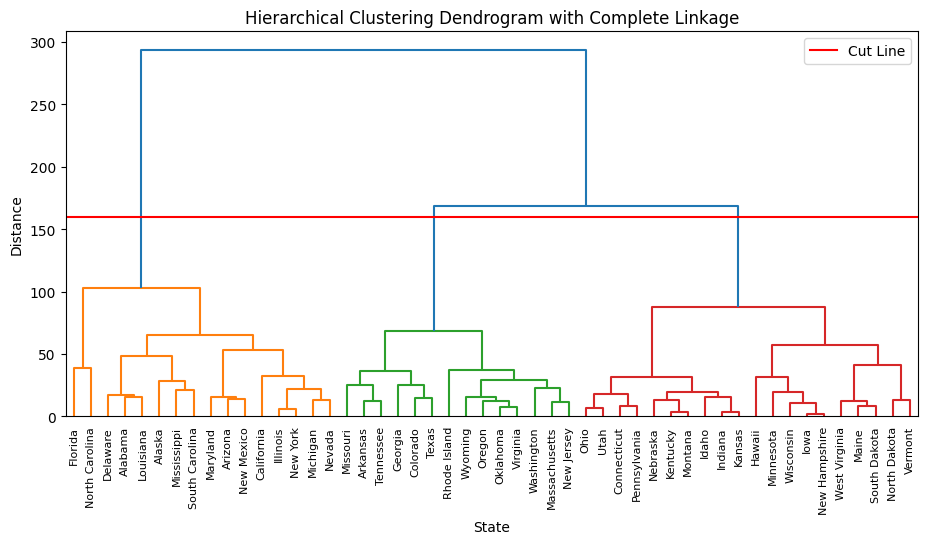

States in each Cluster:
         Cluster 0      Cluster 1      Cluster 2
0          Alabama       Arkansas    Connecticut
1           Alaska       Colorado         Hawaii
2          Arizona        Georgia          Idaho
3       California  Massachusetts        Indiana
4         Delaware       Missouri           Iowa
5          Florida     New Jersey         Kansas
6         Illinois       Oklahoma       Kentucky
7        Louisiana         Oregon          Maine
8         Maryland   Rhode Island      Minnesota
9         Michigan      Tennessee        Montana
10     Mississippi          Texas       Nebraska
11          Nevada       Virginia  New Hampshire
12      New Mexico     Washington   North Dakota
13        New York        Wyoming           Ohio
14  North Carolina           None   Pennsylvania
15  South Carolina           None   South Dakota
16            None           None           Utah
17            None           None        Vermont
18            None           None  West Virgi

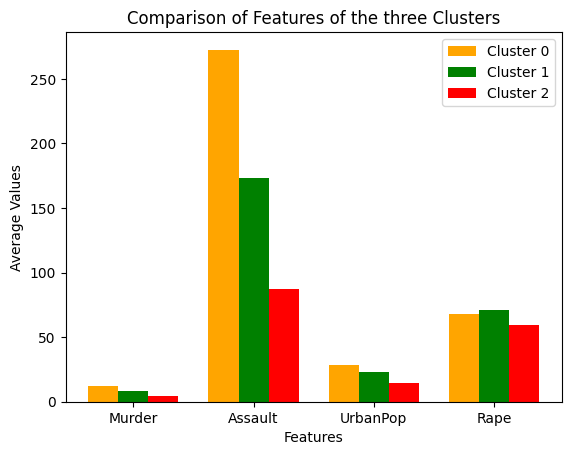

In [14]:
# 3.1.0
# importing packages
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, to_tree, cut_tree

# load the data into a dataframe
data = pd.read_csv('USArrests.csv')

# drop the states columns
x = data.drop("State", axis=1)

# link the clusters using specified arguments
x_linked = linkage(x, method='complete', metric='euclidean')

# plot the dendrogram
plt.figure(figsize=(11,5))
dendrogram(x_linked, labels=data['State'].values, color_threshold=150)
plt.title("Hierarchical Clustering Dendrogram with Complete Linkage")
plt.xlabel("State")
plt.ylabel("Distance")
plt.axhline(y=160, color="red", label="Cut Line")
plt.legend()
plt.show()

# Sort states into each cluster
clusters = cut_tree(x_linked, n_clusters=3)
cluster_list = [[], [], []]
index = 0
while index < len(data["State"]):
    cluster_list[clusters[index][0]].append(data["State"][index])
    index += 1

# plot the average values of the features of each cluster to visualise the defining characteristics
x_p = data.copy()
# add the cluster number to the dataframe 
x_p["Cluster"] = clusters

# get lists of state data for each cluster
plt_c0 = x_p[x_p["Cluster"] == 0]
plt_c1 = x_p[x_p["Cluster"] == 1]
plt_c2 = x_p[x_p["Cluster"] == 2] 

# print the states in each cluster using a dataframe
cluster_state_df = pd.DataFrame(cluster_list)
cluster_state_df = cluster_state_df.T
cluster_state_df.columns = ["Cluster 0", "Cluster 1", "Cluster 2"]
print("States in each Cluster:")
print(cluster_state_df)

# store the average feature values
plt_c0 = [plt_c0["Murder"].mean(), plt_c0["Assault"].mean(), plt_c0["Rape"].mean(), plt_c0["UrbanPop"].mean()]
plt_c1 = [plt_c1["Murder"].mean(), plt_c1["Assault"].mean(), plt_c1["Rape"].mean(), plt_c1["UrbanPop"].mean()]
plt_c2 = [plt_c2["Murder"].mean(), plt_c2["Assault"].mean(), plt_c2["Rape"].mean(), plt_c2["UrbanPop"].mean()]

# plot a bar chart to compare the values across the three clusters
bw = 0.25
xpos = np.arange(len(x.columns))
plt.bar(xpos, plt_c0, width=bw, label="Cluster 0", color="orange")
plt.bar(xpos + bw, plt_c1, width=bw, label="Cluster 1", color="green")
plt.bar(xpos + 2*bw, plt_c2, width=bw, label="Cluster 2", color="red")
plt.xlabel("Features")
plt.ylabel("Average Values")
plt.title("Comparison of Features of the three Clusters")
plt.xticks(xpos+bw, x.columns)
plt.legend()
plt.show()

## Task 2

## 3.2 Performing Hierarchical Clustering on Scaled Data

Scaling the US Arrests data to have zero mean and unit standard deviation using standard scaling will reduce the impact of outliers, and work to equalize the influence of the four features, yielding a better model. The resulting dendrogram looks rather different to the one in task one. We cut the dendrogram into three groups at a distance of approximately 4.45, though one of the groups dominates the dataset, containg 31 of the 50 states. From looking at the graph, the model would more naturally fit into four empirical clusters, splitting the orange cluster in two, as the current height at which the orange cluster merges into the other clusters is very large, larger than the two other clusters.

The shape of the clusters on this dendrogram also varies from the task one, with the heights of the initial state merges on average larger than the original, indicating the impact of scaling reducing bias and outliers within the state data. This confirms the need for scaling to remove the influence of the different scales the feature data has - urban pop as a percentage, with murder counts much lower than assaults. The larger euclidean distances in the dendrogram from task one are likely the result of the feature variables on a larger scale being compared to the ones on a small scale. Removing this bias will allow the hierarchical clustering algorithm to make better grouping decisions on the feature data, improving the dissimilarity between the clusters.

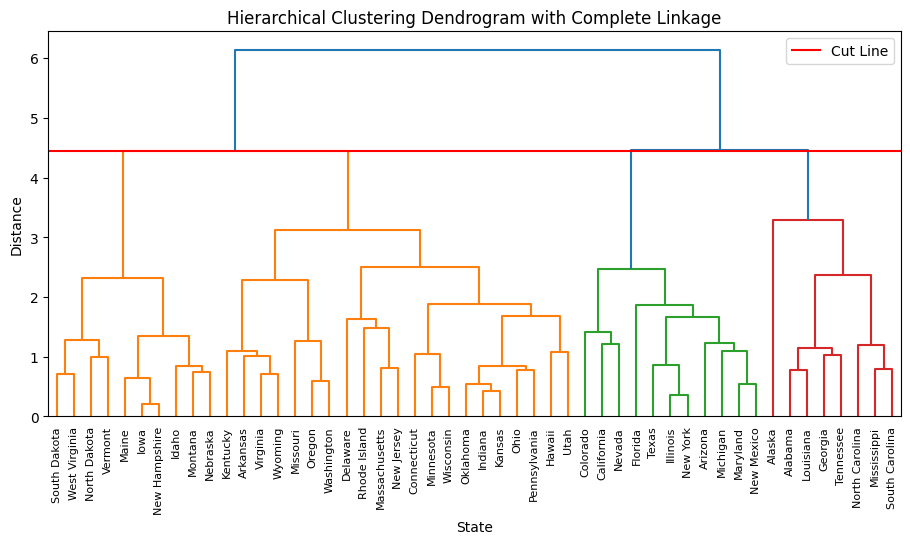

States in each Cluster:
         Cluster 0   Cluster 1      Cluster 2
0          Alabama     Arizona       Arkansas
1           Alaska  California    Connecticut
2          Georgia    Colorado       Delaware
3        Louisiana     Florida         Hawaii
4      Mississippi    Illinois          Idaho
5   North Carolina    Maryland        Indiana
6   South Carolina    Michigan           Iowa
7        Tennessee      Nevada         Kansas
8             None  New Mexico       Kentucky
9             None    New York          Maine
10            None       Texas  Massachusetts
11            None        None      Minnesota
12            None        None       Missouri
13            None        None        Montana
14            None        None       Nebraska
15            None        None  New Hampshire
16            None        None     New Jersey
17            None        None   North Dakota
18            None        None           Ohio
19            None        None       Oklahoma
20        

In [15]:
# 3.2.0
# separating the states column from the features
x = data.drop("State", axis=1)

# scaling the data
scaler = StandardScaler()
x = scaler.fit_transform(x)
x = pd.DataFrame(x, columns=data.drop("State", axis=1).columns)

# link the clusters using specified arguments
x_linked = linkage(x, method='complete', metric='euclidean')

# plot the dendrogram
plt.figure(figsize=(11,5))
dendrogram(x_linked, labels=data['State'].values, color_threshold=4.45)
plt.title("Hierarchical Clustering Dendrogram with Complete Linkage")
plt.xlabel("State")
plt.ylabel("Distance")
plt.axhline(y=4.45, color="red", label="Cut Line")
plt.legend()
plt.show()

# sort the states into their corresponding clusters 
clusters = cut_tree(x_linked, n_clusters=3)
cluster_list = [[], [], []]
index = 0
while index < len(data["State"]):
    cluster_list[clusters[index][0]].append(data["State"][index])
    index += 1
    
# print the states in each cluster using a dataframe
cluster_state_df = pd.DataFrame(cluster_list)
cluster_state_df = cluster_state_df.T
cluster_state_df.columns = ["Cluster 0", "Cluster 1", "Cluster 2"]
print("States in each Cluster:")
print(cluster_state_df)    


## Task 3

## 3.0 Performing Hierarchical Clustering on PCA data

PCA is performed on the scaled data from task two, yielding two principal components for hierarchical clustering analysis. The PCA values have also been scaled using min/max scaling in preparation for the clustering algorithm. The same hierarchical clustering is performed as in task one and two to produce a dendrogram, along with a scatter plot visualising the three clusters product of the two principal components after hierarchical clustering.

Analysing the dendrogram, we compare its similarity the the dendrogram from the previous part. They appear to share a lot of similarities, the orange group remaining the dominant in number of states, which could again be split quite naturally into two more evenly sized clusters. It also appears that the red cluster has gotten larger, and the green cluster has gotten smaller. The branch distances here however are shorter than in task two's dendrogram, and from this we can decipher the states are not as dissimilar as in task two. The height at which the three clusters combine into two is similar, but lower than in task two, again nodding to the previous clustering algorithm finding better dissimilarity between the states than the PCA algorithm.

The scatter plot depicts a distinct separation between the three clusters, with no overlapping datapoints on the graph, however the group sizes, as in the dendrogram, are not roughly equal, and are still dominated by the orange group. the red and green groups appear to correlate to a higher first principal component value (~>0.1), the red group with a second principal component value of above 0.2. The orange datapoints span the entire of the second component values with a first component value of <0.1.

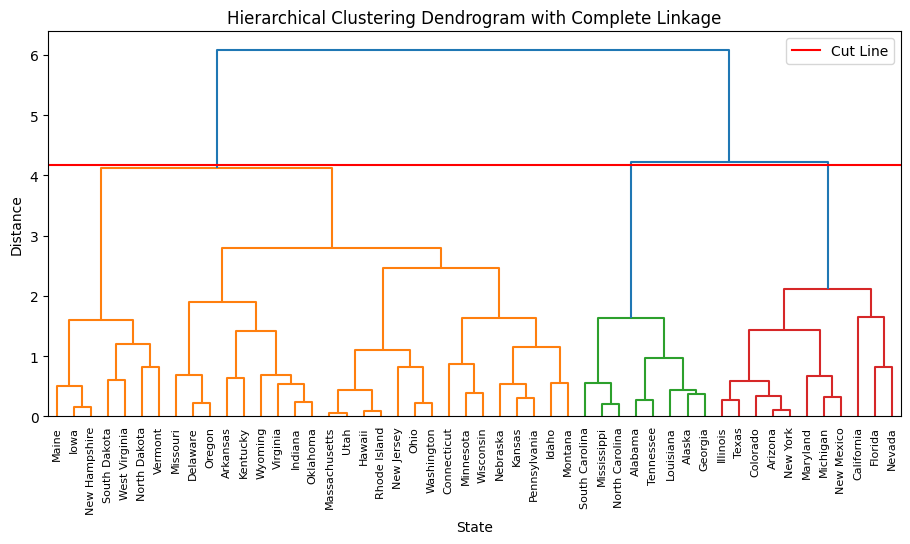

States in each Cluster:
         Cluster 0   Cluster 1      Cluster 2
0          Alabama     Arizona       Arkansas
1           Alaska  California    Connecticut
2          Georgia    Colorado       Delaware
3        Louisiana     Florida         Hawaii
4      Mississippi    Illinois          Idaho
5   North Carolina    Maryland        Indiana
6   South Carolina    Michigan           Iowa
7        Tennessee      Nevada         Kansas
8             None  New Mexico       Kentucky
9             None    New York          Maine
10            None       Texas  Massachusetts
11            None        None      Minnesota
12            None        None       Missouri
13            None        None        Montana
14            None        None       Nebraska
15            None        None  New Hampshire
16            None        None     New Jersey
17            None        None   North Dakota
18            None        None           Ohio
19            None        None       Oklahoma
20        

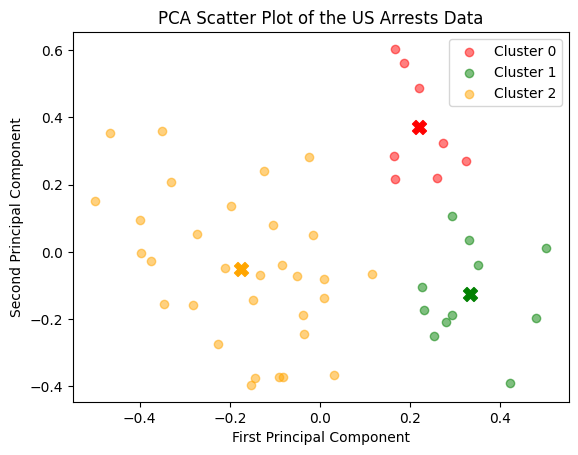

In [16]:
# 3.3.0
# performing PCA for two principal components
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

# lists for each principal component
PC1 = x_pca[:, 0]
PC2 = x_pca[:, 1]

# setting scale of the principal components
PC1_scale = 1 / (max(PC1) - min(PC1))
PC2_scale = 1 / (max(PC2) - min(PC2))

# construct dataframe containing the principal component values and their corresponding labels
zipped = list(zip(PC1 * PC1_scale, PC2 * PC2_scale, data["State"]))
pc_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', 'states'])

# link the clusters using the specified method and metric
x_linked = linkage(x_pca, method='complete', metric='euclidean')

# plot the dendrogram
plt.figure(figsize=(11,5))
dendrogram(x_linked, labels=data['State'].values, color_threshold=4.18)
plt.title("Hierarchical Clustering Dendrogram with Complete Linkage")
plt.xlabel("State")
plt.ylabel("Distance")
plt.axhline(y=4.18, color="red", label="Cut Line")
plt.legend()
plt.show()

# Sort states into each cluster
clusters = cut_tree(x_linked, n_clusters=3)
cluster_list = [[], [], []]
index = 0
while index < len(data["State"]):
    cluster_list[clusters[index][0]].append(data["State"][index])
    index += 1
    
# print the states in each cluster using a dataframe
cluster_state_df = pd.DataFrame(cluster_list)
cluster_state_df = cluster_state_df.T
cluster_state_df.columns = ["Cluster 0", "Cluster 1", "Cluster 2"]
print("States in each Cluster:")
print(cluster_state_df)    

# get lists of state data for each cluster
pc_df["Cluster"] = clusters
plt_c0 = pc_df[pc_df["Cluster"] == 0]
plt_c1 = pc_df[pc_df["Cluster"] == 1]
plt_c2 = pc_df[pc_df["Cluster"] == 2] 

# get centroids
centroids = [plt_c0["PC1"].mean(), plt_c0["PC2"].mean(),
             plt_c1["PC1"].mean(), plt_c1["PC2"].mean(),
             plt_c2["PC1"].mean(), plt_c2["PC2"].mean()]   

# plot a scatterplot of the PCA component values
plt.scatter(plt_c0['PC1'], plt_c0["PC2"], alpha=0.5, label="Cluster 0", c="r")
plt.scatter(plt_c1["PC1"], plt_c1["PC2"], alpha=0.5, label="Cluster 1", c="green")
plt.scatter(plt_c2["PC1"], plt_c2["PC2"], alpha=0.5, label="Cluster 2", c="orange")
plt.scatter(centroids[0], centroids[1], marker='X', c='r', s=100)
plt.scatter(centroids[2], centroids[3], marker='X', c='green', s=100)
plt.scatter(centroids[4], centroids[5], marker='X', c='orange', s=100)
plt.title("PCA Scatter Plot of the US Arrests Data")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.show()

## Task 4

## 4.0 K-Means Clustering of the PCA data and Comparison with Hierarchical Clustering

The centroid values from task three have been taken and used as the initial centroids for k-means clustering. This will give the algorithm a foundation that will yield a similar result to the scatterplot from task three, however slightly different results may appear at the 'edges' of the clusters as the k-means clustering works by minimising the variation within a cluster, while the previous hierarchical clustering method works to minimise the maximum difference between clusters. 

Analysing our scatterplot, we can see this is the case, as some of the orange datapoints have been 'donated' to the green and red clusters, reducing the maximum distance between the clusters by extending the smaller ones towards the center. 

The hierarchical clustering method has probably generated a better result, with a more distinctive boundary between the clusters. The K-means clustering method has selected points along the cluster boundaries smaller groups where the hierarchical method has placed these points with the cluster with the closest original centroid. 

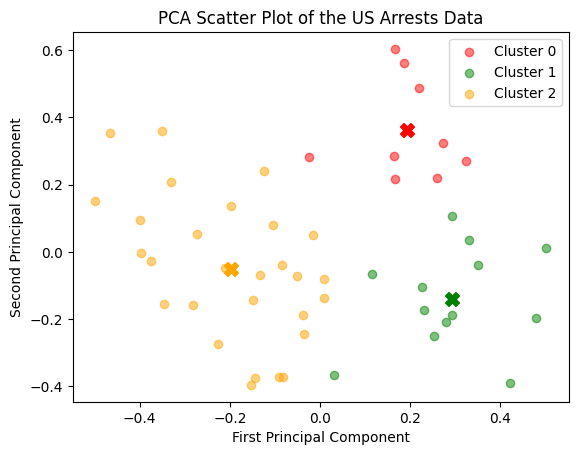

In [17]:
# 3.4.0
# store the centroids of each cluster
c0 = [np.average(plt_c0['PC1']), np.average(plt_c0["PC2"])]
c1 = [np.average(plt_c1['PC1']), np.average(plt_c1["PC2"])]
c2 = [np.average(plt_c2['PC1']), np.average(plt_c2["PC2"])]
centroids = [c0, c1, c2]

# drop the cluster labels from task 3
pc_df = pc_df.drop(["Cluster", "states"], axis=1)

# perform the kmeans clustering
kmeans = KMeans(n_clusters=3, init=centroids, n_init=1, random_state=random_state)
kmeans.fit(pc_df)

# add the target labels from the kmeans clustering back to the pc dataframe
pc_df['Cluster'] = kmeans.labels_
centroids = kmeans.cluster_centers_
 
# get lists of state data for each cluster
plt_c0 = pc_df[pc_df["Cluster"] == 0]
plt_c1 = pc_df[pc_df["Cluster"] == 1]
plt_c2 = pc_df[pc_df["Cluster"] == 2] 

# plot a scatterplot of the PCA component values
plt.scatter(plt_c0['PC1'], plt_c0["PC2"], alpha=0.5, label="Cluster 0", c="r")
plt.scatter(plt_c1["PC1"], plt_c1["PC2"], alpha=0.5, label="Cluster 1", c="green")
plt.scatter(plt_c2["PC1"], plt_c2["PC2"], alpha=0.5, label="Cluster 2", c="orange")
plt.scatter(centroids[0, 0], centroids[0, 1], marker='X', c='r', s=100)
plt.scatter(centroids[1, 0], centroids[1, 1], marker='X', c='green', s=100)
plt.scatter(centroids[2, 0], centroids[2, 1], marker='X', c='orange', s=100)
plt.title("PCA Scatter Plot of the US Arrests Data")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.legend()
plt.show()